# MNE-pythonの基礎を学ぶ

## おまじないとロード

In [1]:
import os
import mne
import numpy as np
import matplotlib.pyplot as plt

In [2]:
sample_data_folder = mne.datasets.sample.data_path()
sample_data_raw_file = os.path.join(sample_data_folder, 'MEG', 'sample',
                                    'sample_audvis_filt-0-40_raw.fif')
raw = mne.io.read_raw_fif(sample_data_raw_file)

Opening raw data file C:\Users\goto\mne_data\MNE-sample-data\MEG\sample\sample_audvis_filt-0-40_raw.fif...
    Read a total of 4 projection items:
        PCA-v1 (1 x 102)  idle
        PCA-v2 (1 x 102)  idle
        PCA-v3 (1 x 102)  idle
        Average EEG reference (1 x 60)  idle
    Range : 6450 ... 48149 =     42.956 ...   320.665 secs
Ready.


C:\Users\goto\anaconda3\lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


In [3]:
print(raw)
print(raw.info)

<Raw | sample_audvis_filt-0-40_raw.fif, 376 x 41700 (277.7 s), ~3.3 MB, data not loaded>
<Info | 15 non-empty values
 bads: 2 items (MEG 2443, EEG 053)
 ch_names: MEG 0113, MEG 0112, MEG 0111, MEG 0122, MEG 0123, MEG 0121, MEG ...
 chs: 204 Gradiometers, 102 Magnetometers, 9 Stimulus, 60 EEG, 1 EOG
 custom_ref_applied: False
 dev_head_t: MEG device -> head transform
 dig: 146 items (3 Cardinal, 4 HPI, 61 EEG, 78 Extra)
 file_id: 4 items (dict)
 highpass: 0.1 Hz
 hpi_meas: 1 item (list)
 hpi_results: 1 item (list)
 lowpass: 40.0 Hz
 meas_date: 2002-12-03 19:01:10 UTC
 meas_id: 4 items (dict)
 nchan: 376
 projs: PCA-v1: off, PCA-v2: off, PCA-v3: off, Average EEG reference: off
 sfreq: 150.2 Hz
>


## ノイズの確認，PSD

In [4]:
fig = raw.plot_psd(fmax=50, picks="data", exclude="bads")
fig.savefig('../figures/psd_plot.png')  # PNG形式で保存。必要に応じてファイル名や拡張子を変更

NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 13.639 (s)


C:\Users\goto\anaconda3\lib\site-packages\mne\viz\utils.py:161: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  (fig or plt).show(**kwargs)


In [5]:
raw.plot(duration=5)

Using qt as 2D backend.


In [6]:
sample_data_folder = mne.datasets.sample.data_path()
sample_data_raw_file = os.path.join(
    sample_data_folder, "MEG", "sample", "sample_audvis_raw.fif")
raw = mne.io.read_raw_fif(sample_data_raw_file)
raw.crop(0, 60).load_data()  # just use a fraction of data for 

Opening raw data file C:\Users\goto\mne_data\MNE-sample-data\MEG\sample\sample_audvis_raw.fif...
    Read a total of 3 projection items:
        PCA-v1 (1 x 102)  idle
        PCA-v2 (1 x 102)  idle
        PCA-v3 (1 x 102)  idle
    Range : 25800 ... 192599 =     42.956 ...   320.670 secs
Ready.
Reading 0 ... 36037  =      0.000 ...    60.000 secs...


<Raw | sample_audvis_raw.fif, 376 x 36038 (60.0 s), ~106.7 MB, data loaded>

In [7]:
ssp_projectors = raw.info["projs"]
raw.del_proj()

<Raw | sample_audvis_raw.fif, 376 x 36038 (60.0 s), ~106.6 MB, data loaded>

In [8]:
mag_channels = mne.pick_types(raw.info, meg="mag")
raw.plot(duration=60, order=mag_channels, n_channels=len(mag_channels), remove_dc=False)

In [9]:
%matplotlib inline
fig = raw.compute_psd(tmax=np.inf, fmax=250).plot(
    average=True, picks="data", exclude="bads"
)
# add some arrows at 60 Hz and its harmonics:
for ax in fig.axes[1:]:
    freqs = ax.lines[-1].get_xdata()
    psds = ax.lines[-1].get_ydata()
    for freq in (60, 120, 180, 240):
        idx = np.searchsorted(freqs, freq)
        ax.arrow(
            x=freqs[idx],
            y=psds[idx] + 18,
            dx=0,
            dy=-12,
            color="red",
            width=0.1,
            head_width=3,
            length_includes_head=True,
        )
fig.savefig('../figures/mne-pre3.png')

Effective window size : 3.410 (s)


C:\Users\goto\anaconda3\lib\site-packages\mne\viz\utils.py:161: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  (fig or plt).show(**kwargs)


## ECG and EOG

Reconstructing ECG signal from Magnetometers
Setting up band-pass filter from 8 - 16 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 8.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 7.75 Hz)
- Upper passband edge: 16.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 16.25 Hz)
- Filter length: 6007 samples (10.001 s)

Number of ECG events detected : 59 (average pulse 58 / min.)
Not setting metadata
59 matching events found
Applying baseline correction (mode: mean)
Using data from preloaded Raw for 59 events and 601 original time points ...
0 bad epochs dropped
Not setting metadata
59 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
59 matching events found
No baseline correction applied
0 projection items activated
Not setting

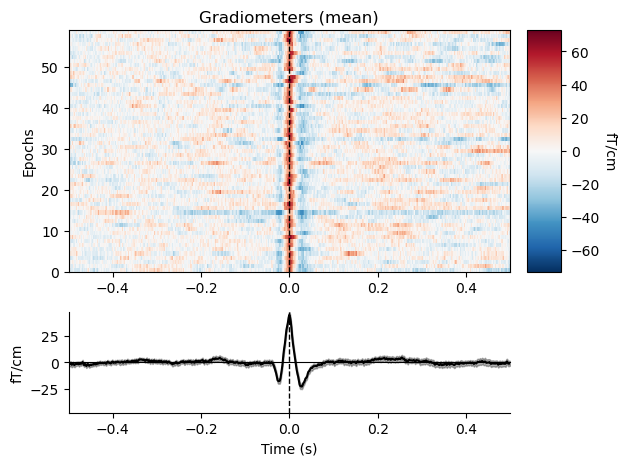

In [10]:
ecg_epochs = mne.preprocessing.create_ecg_epochs(raw, baseline=(-0.5,-0.2))
fig = ecg_epochs.plot_image(combine="mean")


fig[0].savefig('../figures/mne-ecg11.png')
fig[1].savefig('../figures/mne-ecg21.png')
fig[2].savefig('../figures/mne-ecg31.png')

In [11]:
avg_ecg_epochs = ecg_epochs.average()
fig = avg_ecg_epochs.plot_topomap(times=np.linspace(-0.05, 0.05, 11))
fig.savefig('../figures/mne-ecg6.png')

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


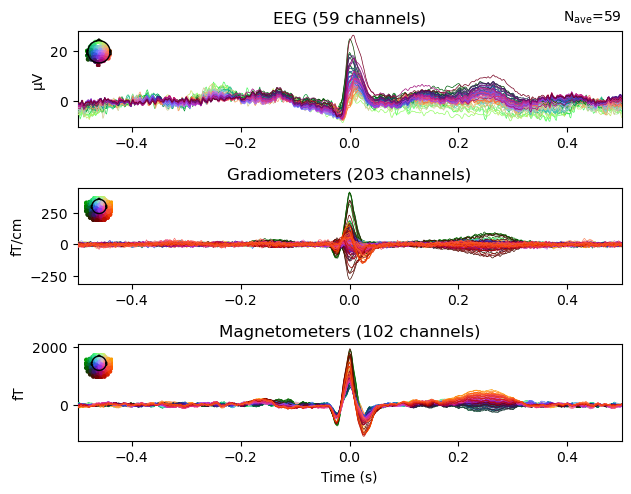

In [12]:
fig = avg_ecg_epochs.plot()

fig.savefig('../figures/mne-ecg7.png')

No projector specified for this dataset. Please consider the method self.add_proj.
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


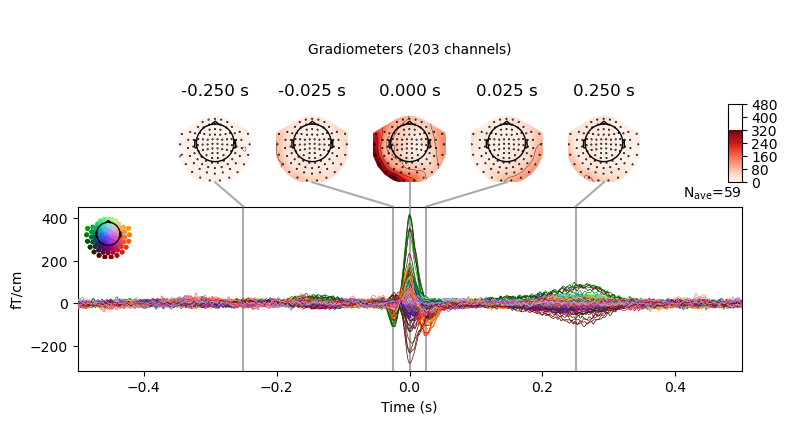

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


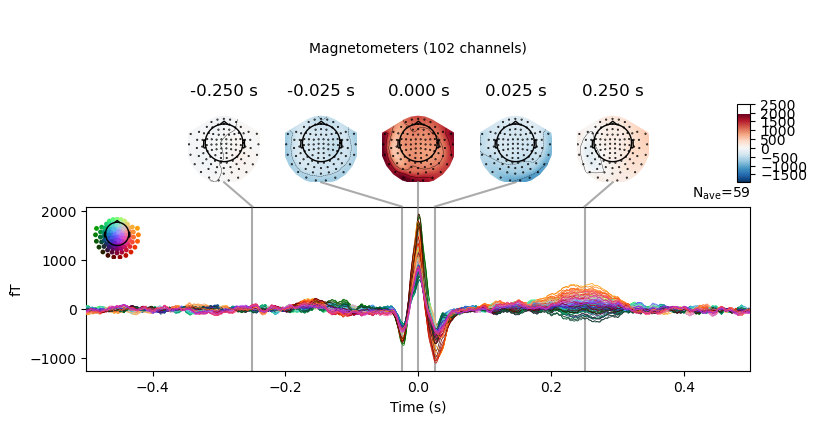

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


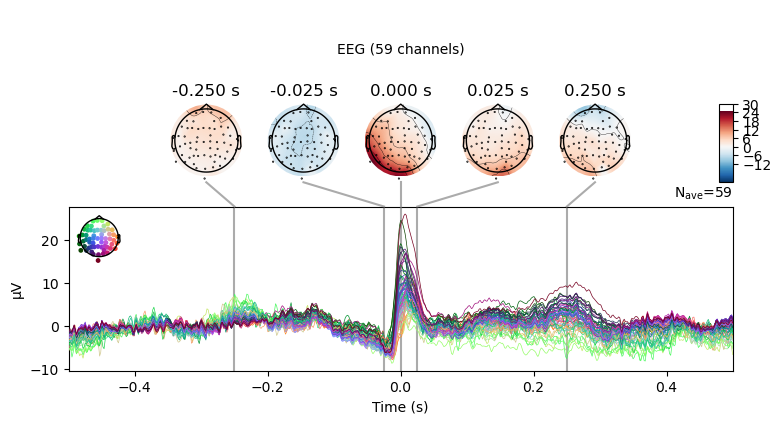

In [13]:
fig = avg_ecg_epochs.plot_joint(times=[-0.25, -0.025, 0, 0.025, 0.25])

#fig[0].savefig('../figures/mne-ecg12.png')
#fig[1].savefig('../figures/mne-ecg22.png')
#fig[2].savefig('../figures/mne-ecg32.png')

Using EOG channel: EOG 061
EOG channel index for this subject is: [375]
Filtering the data to remove DC offset to help distinguish blinks from saccades
Selecting channel EOG 061 for blink detection
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 6007 samples (10.001 s)

Now detecting blinks and generating corresponding events
Found 10 significant peaks
Number of EOG events detected: 10
Not setting metadata
10 matching events found
Applying baseline correction (mode: mean)
Using data from preloaded Raw for 10 events and 601 original time points ...
0 bad epochs dropped
Not setting m

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


0 projection items activated
combining channels using "mean"
combining channels using "mean"
combining channels using "mean"


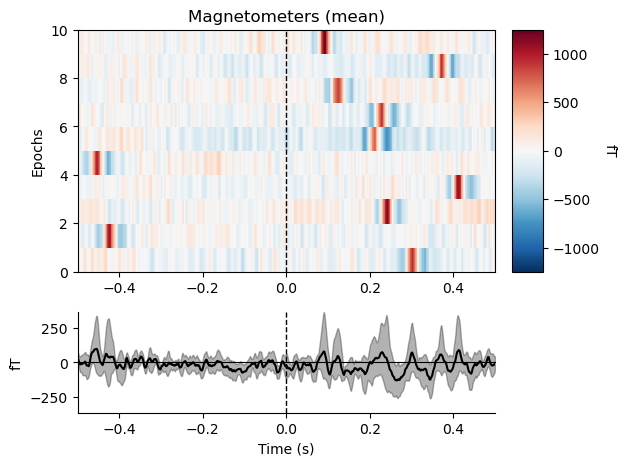

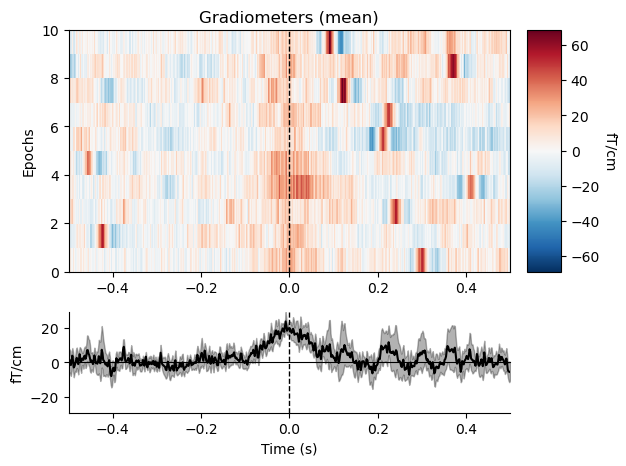

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
No projector specified for this dataset. Please consider the method self.add_proj.
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


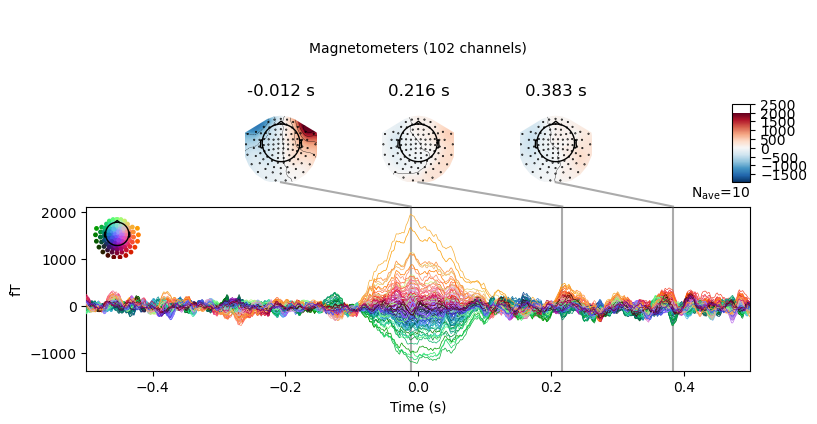

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


In [14]:
eog_epochs = mne.preprocessing.create_eog_epochs(raw, baseline=(-0.5, -0.2))
fig = eog_epochs.plot_image(combine="mean")
fig2 = eog_epochs.average().plot_joint()

#fig[0].savefig('../figures/mne-ecg13.png')
#fig[1].savefig('../figures/mne-ecg23.png')
#fig[2].savefig('../figures/mne-ecg33.png')

#fig2[0].savefig('../figures/mne-ecg14.png')
#fig2[1].savefig('../figures/mne-ecg24.png')
#fig2[2].savefig('../figures/mne-ecg34.png')

## Bad channel

In [15]:
print(raw.info["bads"])

['MEG 2443', 'EEG 053']


In [16]:
picks = mne.pick_channels_regexp(raw.ch_names, regexp="EEG 05.")
raw.plot(order=picks, n_channels=len(picks))

In [17]:
picks = mne.pick_channels_regexp(raw.ch_names, regexp="MEG 2..3")
raw.plot(order=picks, n_channels=len(picks))

In [18]:
# default is exclude='bads':
good_eeg = mne.pick_types(raw.info, meg=False, eeg=True)
all_eeg = mne.pick_types(raw.info, meg=False, eeg=True, exclude=[])
print(np.setdiff1d(all_eeg, good_eeg))
print(np.array(raw.ch_names)[np.setdiff1d(all_eeg, good_eeg)])

[367]
['EEG 053']


In [19]:
raw2 = raw.copy()
raw2.info["bads"] = []
events = mne.find_events(raw2, stim_channel="STI 014")
epochs = mne.Epochs(raw2, events=events)["2"].average().plot()

epochs.savefig('../figures/mne-bc11.png')

86 events found
Event IDs: [ 1  2  3  4  5 32]
Not setting metadata
86 matching events found
Setting baseline interval to [-0.19979521315838786, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


86 events found
Event IDs: [ 1  2  3  4  5 32]
Not setting metadata
86 matching events found
Setting baseline interval to [-0.19979521315838786, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


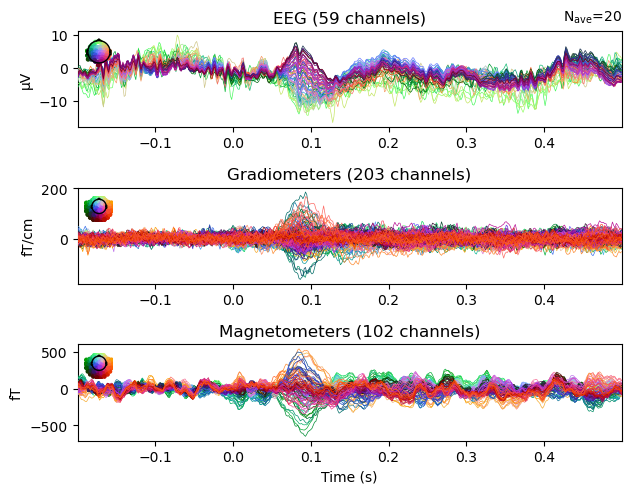

In [20]:
events = mne.find_events(raw, stim_channel="STI 014")
epochs = mne.Epochs(raw, events=events)["2"].average().plot()

epochs.savefig('../figures/mne-bc12.png')

## Filtering

In [21]:
raw3 = raw.copy()
raw3.crop(0,60).pick_types(meg="mag", eeg=False, stim=True).load_data()

NOTE: pick_types() is a legacy function. New code should use inst.pick(...).


<Raw | sample_audvis_raw.fif, 111 x 36038 (60.0 s), ~33.5 MB, data loaded>

In [22]:
raw3.plot(duration=60, proj=False, n_channels=len(raw.ch_names), remove_dc=False)

In [23]:
raw_highpass = raw3.copy().filter(l_freq=0.2, h_freq=None)
with mne.viz.use_browser_backend("matplotlib"):
    fig = raw_highpass.plot(duration=60, proj=False, n_channels=len(raw3.ch_names), remove_dc=False)
fig.subplots_adjust(top=0.9)
fig.suptitle("High-pass filtered at 0.2 Hz", size="xx-large", weight="bold")
fig.savefig('../figures/mne-filt1.png')

Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 0.2 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.20
- Lower transition bandwidth: 0.20 Hz (-6 dB cutoff frequency: 0.10 Hz)
- Filter length: 9911 samples (16.501 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Using matplotlib as 2D backend.


[Parallel(n_jobs=1)]: Done 102 out of 102 | elapsed:    0.1s finished


Using qt as 2D backend.


Setting up high-pass filter at 0.2 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.20
- Lower transition bandwidth: 0.20 Hz (-6 dB cutoff frequency: 0.10 Hz)
- Filter length: 9911 samples (16.501 s)



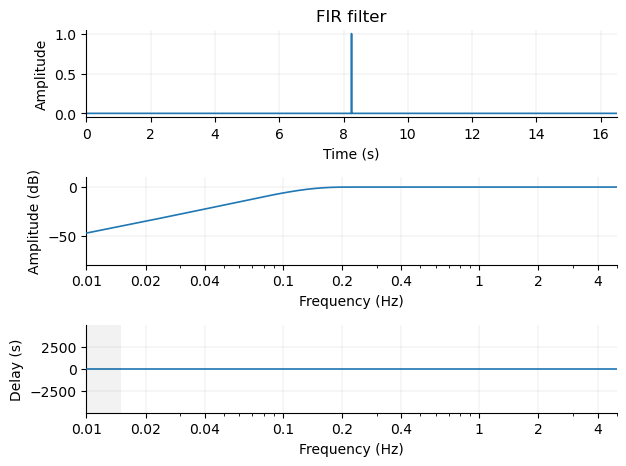

In [24]:
filter_params = mne.filter.create_filter(
    raw3.get_data(), raw3.info["sfreq"], l_freq=0.2, h_freq=None
)
fig = mne.viz.plot_filter(filter_params, raw3.info["sfreq"], flim=(0.01, 5))

fig.savefig('../figures/mne-filt2.png')

In [25]:
filter_params = mne.filter.create_filter(
    raw3.get_data(), raw3.info["sfreq"], l_freq=0.2, h_freq=40
)
fig = mne.viz.plot_filter(filter_params, raw3.info["sfreq"], flim=(0.01, 100))
fig.savefig('../figures/mne-filt4.png')

Setting up band-pass filter from 0.2 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.20
- Lower transition bandwidth: 0.20 Hz (-6 dB cutoff frequency: 0.10 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 9911 samples (16.501 s)



Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.2 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.20
- Lower transition bandwidth: 0.20 Hz (-6 dB cutoff frequency: 0.10 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 9911 samples (16.501 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Using matplotlib as 2D backend.


[Parallel(n_jobs=1)]: Done 102 out of 102 | elapsed:    0.1s finished


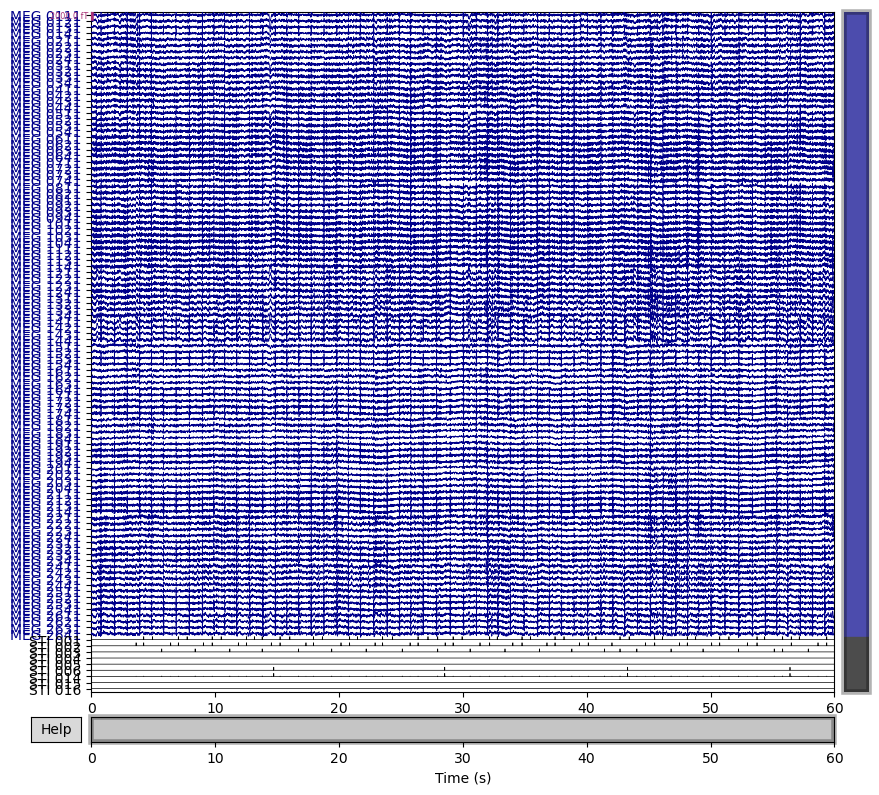

Using qt as 2D backend.


In [26]:
raw_highpass = raw3.copy().filter(l_freq=0.2, h_freq=40)
with mne.viz.use_browser_backend("matplotlib"):
    fig = raw_highpass.plot(duration=60, proj=False, n_channels=len(raw3.ch_names), remove_dc=False)
fig.subplots_adjust(top=0.9)
fig.suptitle("Band-pass filtered 0.2 - 40 Hz", size="xx-large", weight="bold")
fig.savefig('../figures/mne-filt5.png')

Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 3965 samples (6.602 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 3.410 (s)


[Parallel(n_jobs=1)]: Done 305 out of 305 | elapsed:    0.3s finished


NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 3.410 (s)


C:\Users\goto\anaconda3\lib\site-packages\mne\viz\utils.py:161: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  (fig or plt).show(**kwargs)
C:\Users\goto\anaconda3\lib\site-packages\mne\viz\utils.py:161: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  (fig or plt).show(**kwargs)


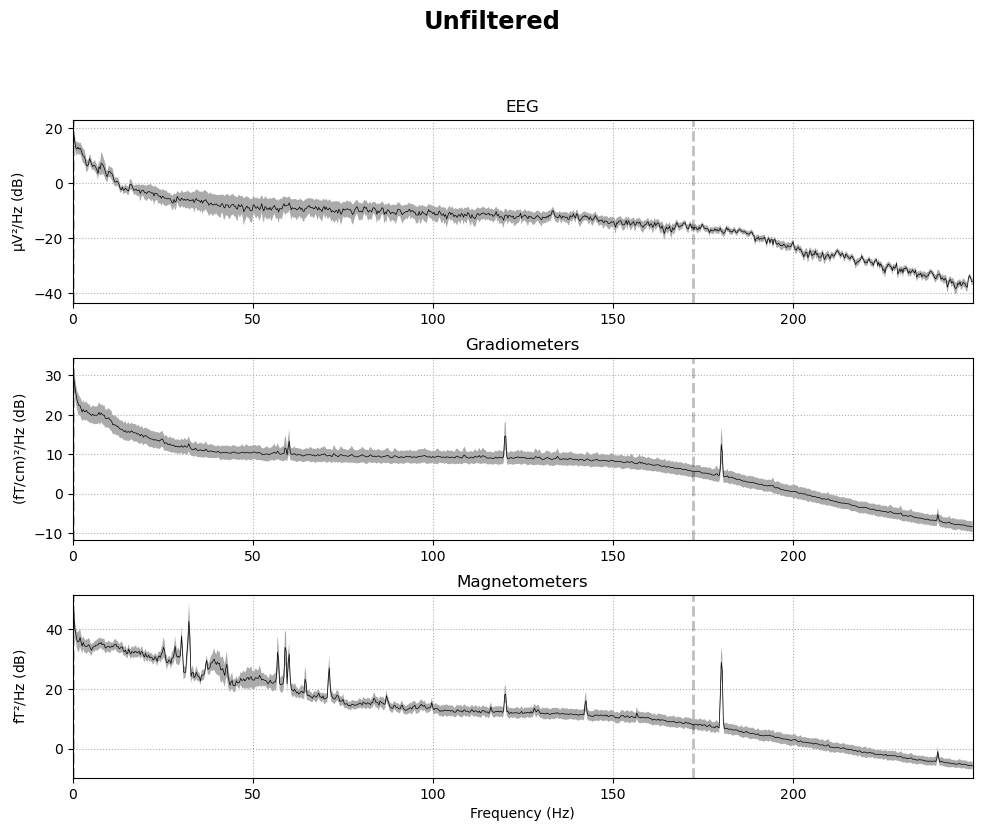

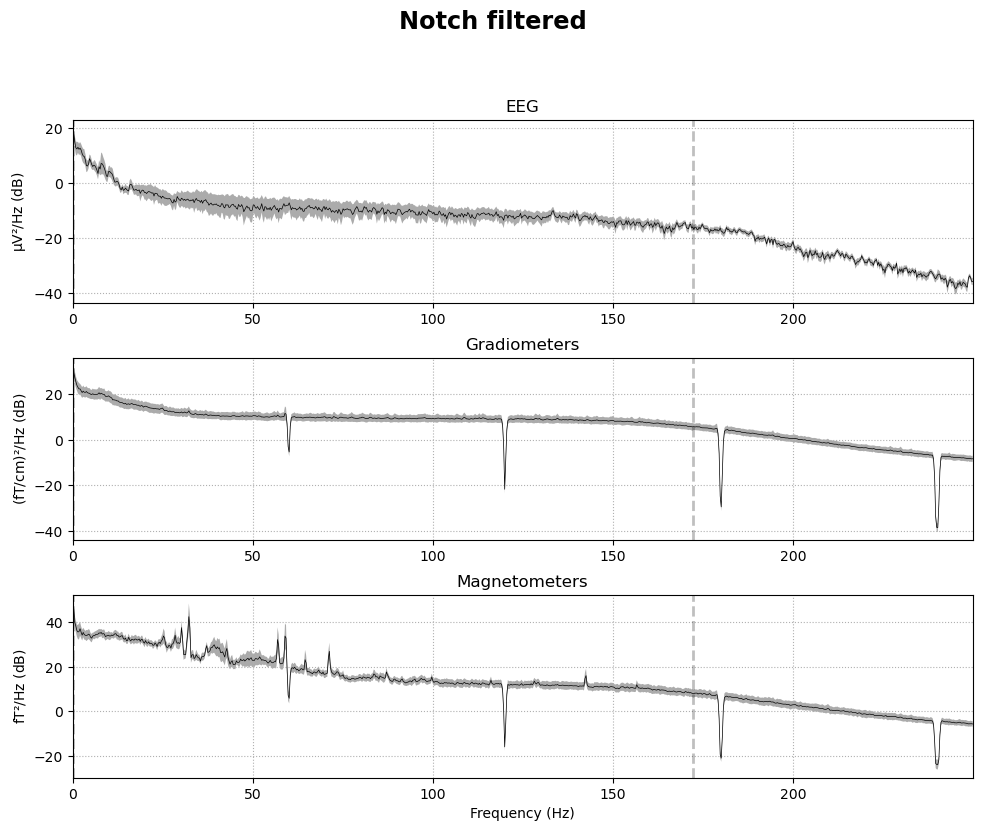

In [27]:
meg_picks = mne.pick_types(raw.info, meg=True)
freqs = (60, 120, 180, 240)
raw_notch = raw.copy().notch_filter(freqs=freqs, picks=meg_picks)
for title, data in zip(["Un", "Notch "], [raw, raw_notch]):
    fig = data.plot_psd(fmax=250, average=True, picks="data", exclude="bads")
    fig.subplots_adjust(top=0.85)
    fig.suptitle("{}filtered".format(title), size="xx-large", weight="bold")
    fig.savefig('../figures/mne-filt3' + title + '.png')
    #add_arrows(fig.axes[:2])

## Interpolation

NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Interpolating bad channels
    Automatic origin fit: head of radius 91.0 mm
Computing interpolation matrix from 59 sensor positions
Interpolating 1 sensors
Using matplotlib as 2D backend.


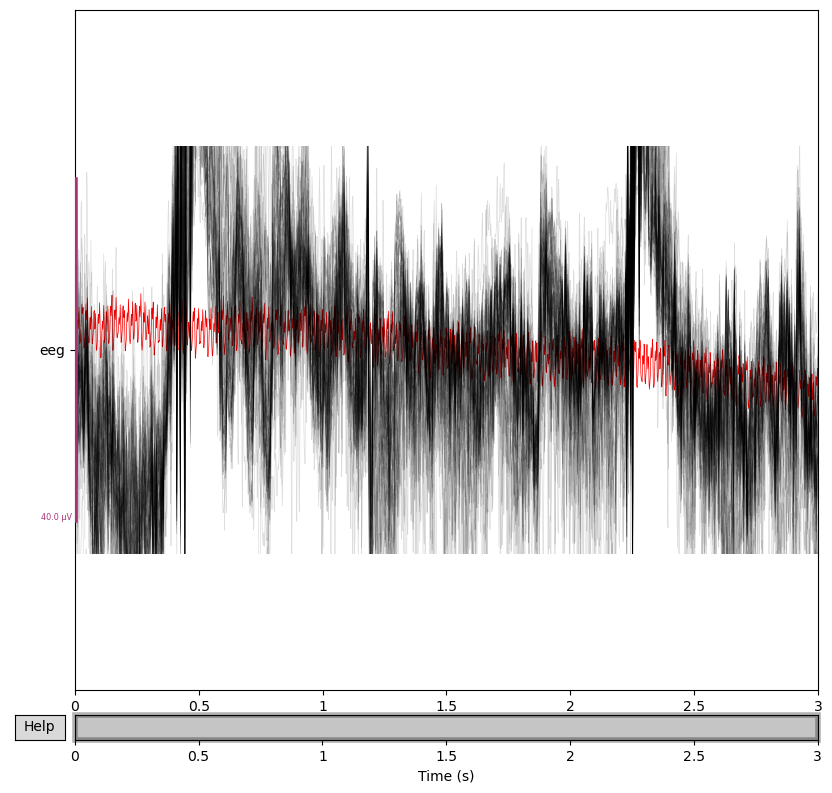

Using qt as 2D backend.
Using matplotlib as 2D backend.


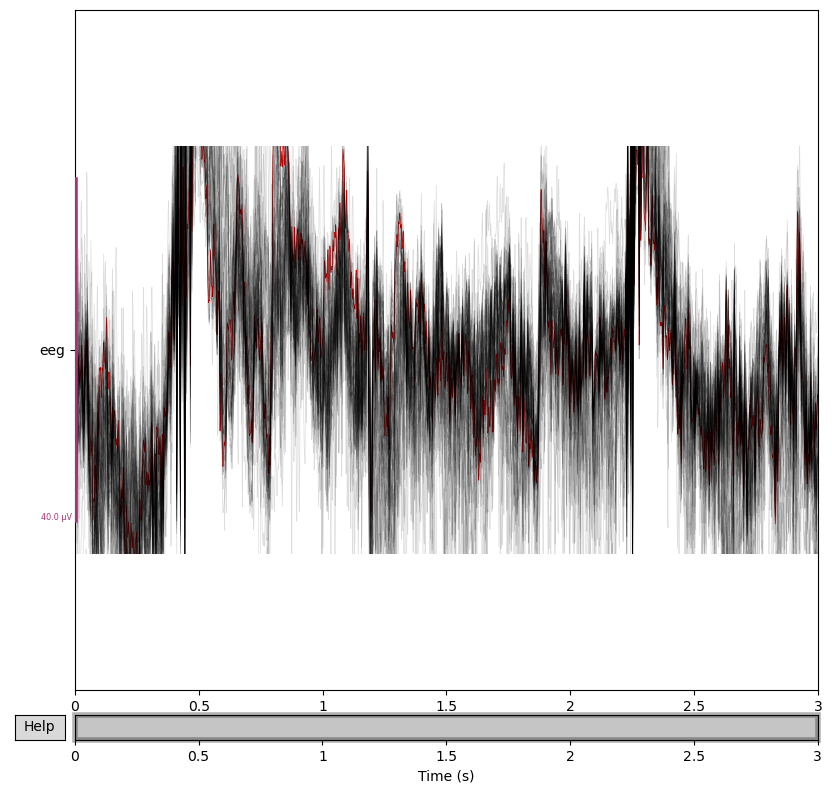

Using qt as 2D backend.


In [28]:
raw4 = raw.copy()
raw4.crop(tmin=0, tmax=3).load_data()

eeg_data = raw4.copy().pick_types(meg=False, eeg=True, exclude=[])
eeg_data_interp = eeg_data.copy().interpolate_bads(reset_bads=False)

for title, data in zip(["orig.", "interp."], [eeg_data, eeg_data_interp]):
    with mne.viz.use_browser_backend("matplotlib"):
        fig = data.plot(butterfly=True, color="#00000022", bad_color="r")
    fig.subplots_adjust(top=0.9)
    fig.suptitle(title, size="xx-large", weight="bold")
    fig.savefig('../figures/mne-bc5'+ title + '.png')

In [29]:
raw.filter(l_freq=0.2, h_freq=40)
raw.notch_filter(freqs=(60,120,180,240))

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.2 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.20
- Lower transition bandwidth: 0.20 Hz (-6 dB cutoff frequency: 0.10 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 9911 samples (16.501 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 3965 samples (6.602 s)



[Parallel(n_jobs=1)]: Done 366 out of 366 | elapsed:    0.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 366 out of 366 | elapsed:    0.4s finished


<Raw | sample_audvis_raw.fif, 376 x 36038 (60.0 s), ~106.6 MB, data loaded>

In [30]:
fig = raw.plot()
#fig.fake_keypress("a")  # Simulates user pressing 'a' on the keyboard.

In [31]:
eog_events = mne.preprocessing.find_eog_events(raw)
onsets = eog_events[:, 0] / raw.info["sfreq"] - 0.25
durations = [0.5] * len(eog_events)
descriptions = ["bad blink"] * len(eog_events)
blink_annot = mne.Annotations(
    onsets, durations, descriptions, orig_time=raw.info["meas_date"]
)
raw.set_annotations(blink_annot)

eeg_picks = mne.pick_types(raw.info, meg=False, eeg=True)
raw.plot(events=eog_events, order=eeg_picks)

Using EOG channel: EOG 061
EOG channel index for this subject is: [375]
Filtering the data to remove DC offset to help distinguish blinks from saccades
Selecting channel EOG 061 for blink detection
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 6007 samples (10.001 s)

Now detecting blinks and generating corresponding events
Found 10 significant peaks
Number of EOG events detected: 10


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


In [32]:
reject_criteria = dict(
    mag=3000e-15,  # 3000 fT
    grad=3000e-13,  # 3000 fT/cm
    eeg=100e-6,  # 100 µV
    eog=200e-6,
)  # 200 µV

flat_criteria = dict(mag=1e-15, grad=1e-13, eeg=1e-6)  # 1 fT  # 1 fT/cm  # 1 µV

Not setting metadata
86 matching events found
Setting baseline interval to [-0.19979521315838786, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 86 events and 421 original time points ...
    Rejecting  epoch based on MAG : ['MEG 1741', 'MEG 2141']
    Rejecting  epoch based on MAG : ['MEG 1421', 'MEG 1431']
    Rejecting  epoch based on EEG : ['EEG 003', 'EEG 007']
    Rejecting  epoch based on MAG : ['MEG 0141', 'MEG 1421', 'MEG 1541']
13 bad epochs dropped


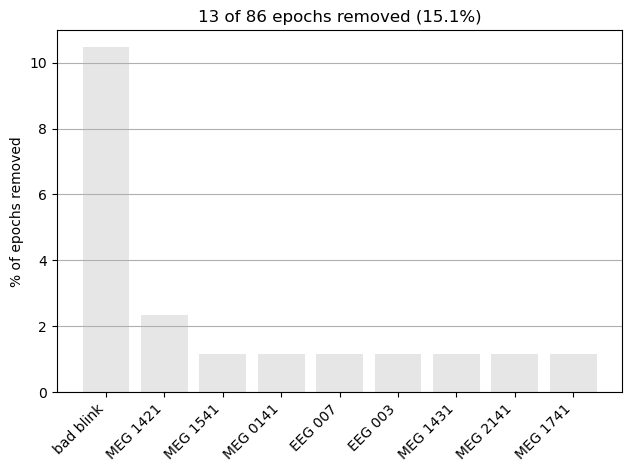

In [33]:
epochs = mne.Epochs(
    raw,
    events,
    tmin=-0.2,
    tmax=0.5,
    reject_tmin=-0.2,
    reject_tmax=0,
    reject=reject_criteria,
    flat=flat_criteria,
    reject_by_annotation=True,
    preload=True,
)
fig = epochs.plot_drop_log()

#fig.savefig('../figures/mne-epoch0.png')

## ICA

In [34]:
from mne.preprocessing import ICA, corrmap, create_ecg_epochs, create_eog_epochs

In [35]:
raw.load_data()

<Raw | sample_audvis_raw.fif, 376 x 36038 (60.0 s), ~106.6 MB, data loaded>

In [36]:
filt_raw = raw.copy().filter(l_freq=1.0, h_freq=None)
filt_raw.load_data()

Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 1983 samples (3.302 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 366 out of 366 | elapsed:    0.3s finished


<Raw | sample_audvis_raw.fif, 376 x 36038 (60.0 s), ~106.6 MB, data loaded>

In [37]:
ica = ICA(n_components=30, method='fastica', max_iter="auto", random_state=97)
ica.fit(filt_raw)
ica

Fitting ICA to data using 364 channels (please be patient, this may take a while)
Omitting 3000 of 36038 (8.32%) samples, retaining 33038 (91.68%) samples.
Selecting by number: 30 components
Fitting ICA took 2.3s.


<ICA | raw data decomposition, method: fastica (fit in 81 iterations on 33038 samples), 30 ICA components (364 PCA components available), channel types: mag, grad, eeg, no sources marked for exclusion>

In [38]:
 ica.plot_sources(filt_raw)

Creating RawArray with float64 data, n_channels=31, n_times=36038
    Range : 25800 ... 61837 =     42.956 ...   102.956 secs
Ready.


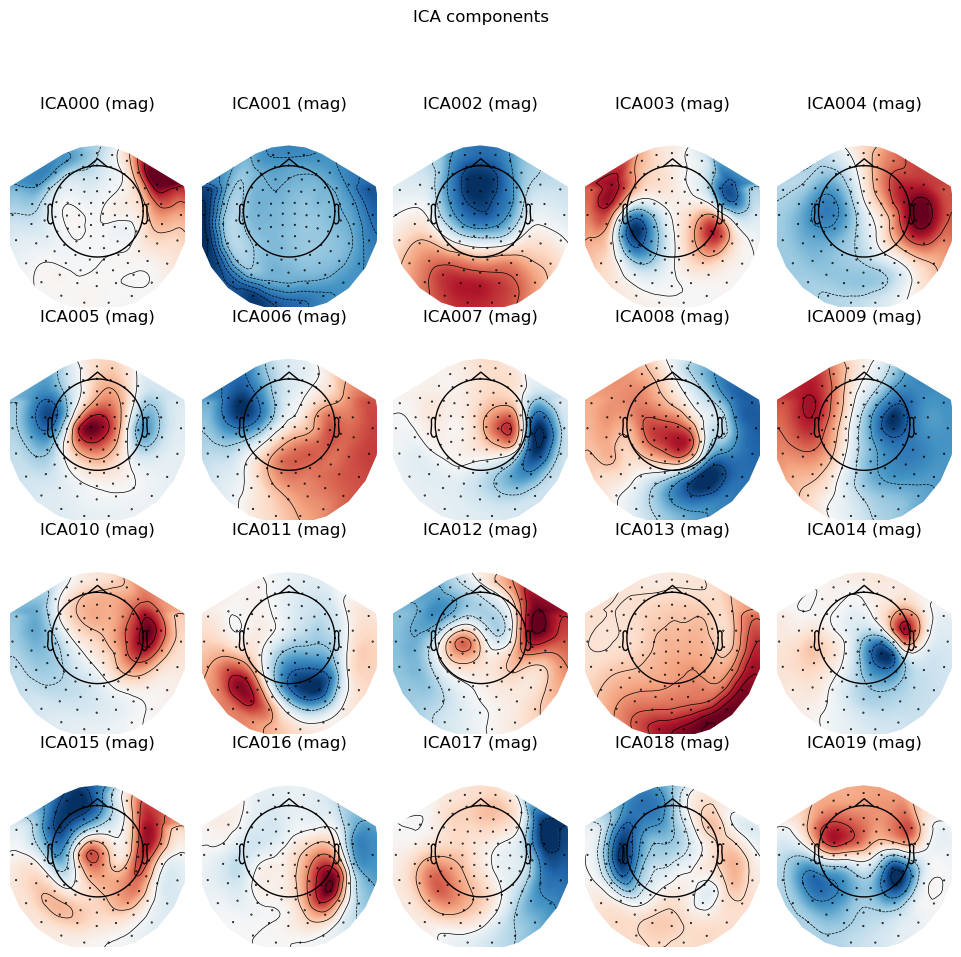

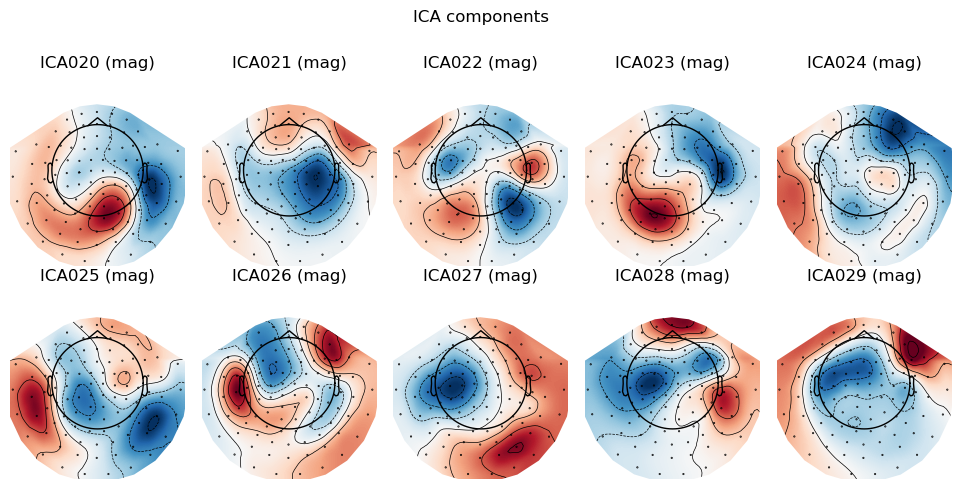

In [39]:
fig = ica.plot_components()
fig[0].savefig('../figures/mne-ica5.png')

In [40]:
# blinks
fig = ica.plot_overlay(raw, exclude=[1, 11, 13], picks="mag")
#fig.savefig('../figures/mne-ica6')

Applying ICA to Raw instance
    Transforming to ICA space (30 components)
    Zeroing out 3 ICA components
    Projecting back using 364 PCA components


In [41]:
ica.exclude = [0, 1, 11, 13]
reconst_raw = raw.copy()
ica.apply(reconst_raw)

Applying ICA to Raw instance
    Transforming to ICA space (30 components)
    Zeroing out 4 ICA components
    Projecting back using 364 PCA components


<Raw | sample_audvis_raw.fif, 376 x 36038 (60.0 s), ~106.6 MB, data loaded>

In [42]:
regexp = r"(MEG [12][45][123]1|EEG 00.)"
artifact_picks = mne.pick_channels_regexp(raw.ch_names, regexp=regexp)
raw.plot(order=artifact_picks, n_channels=len(artifact_picks), show_scrollbars=False)
reconst_raw.plot(
    order=artifact_picks, n_channels=len(artifact_picks), show_scrollbars=False
)
del reconst_raw

Using EOG channel: EOG 061
Omitting 3000 of 36038 (8.32%) samples, retaining 33038 (91.68%) samples.
Omitting 3000 of 36038 (8.32%) samples, retaining 33038 (91.68%) samples.
... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 6007 samples (10.001 s)

... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth:

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


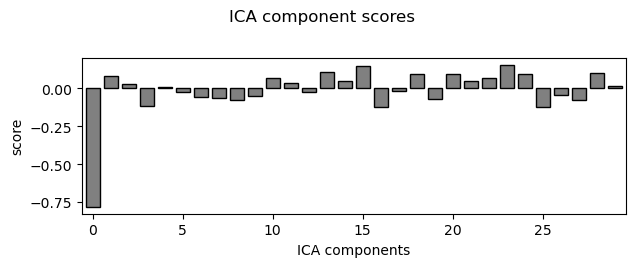

    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
21 matching events found
No baseline correction applied
0 projection items activated


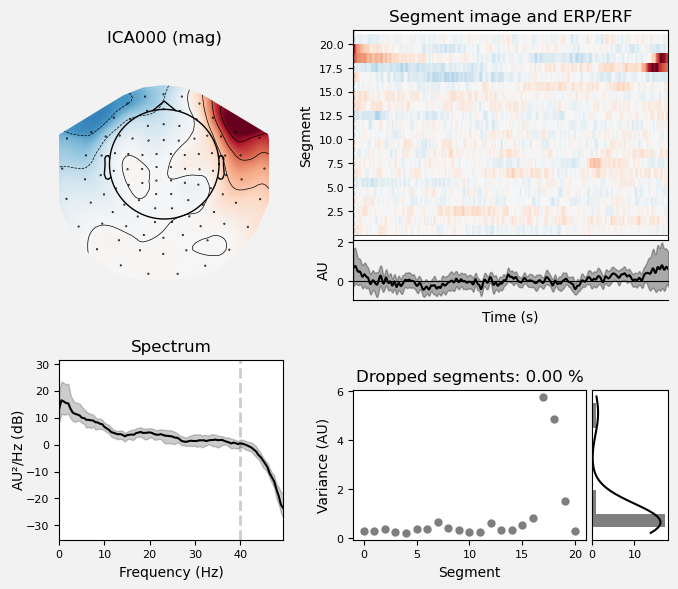

In [51]:
ica.exclude = []
### EOG
eog_indices , eog_scores = ica.find_bads_eog(raw)
fig1 = ica.plot_scores(eog_scores)
fig2 =ica.plot_properties(raw, picks=eog_indices)

fig1.savefig('../figures/mne-ica10.png')
fig2[0].savefig('../figures/mne-ica11.png')

Reconstructing ECG signal from Magnetometers
Omitting 3000 of 36038 (8.32%) samples, retaining 33038 (91.68%) samples.
Omitting 3000 of 36038 (8.32%) samples, retaining 33038 (91.68%) samples.
... filtering ICA sources
Setting up band-pass filter from 8 - 16 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 8.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 7.75 Hz)
- Upper passband edge: 16.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 16.25 Hz)
- Filter length: 6007 samples (10.001 s)

... filtering target
Setting up band-pass filter from 8 - 16 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 8.00
- Lower tra

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


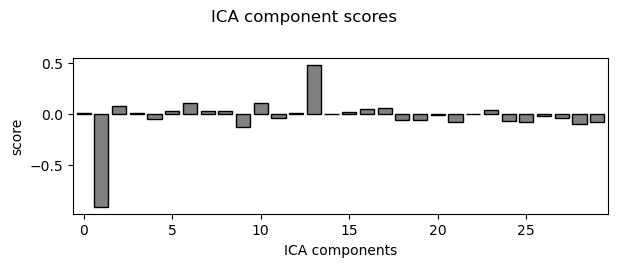

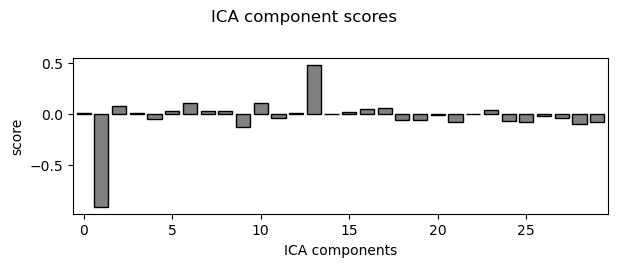

In [54]:
### ECG
ecg_indices, ecg_scores = ica.find_bads_ecg(raw, method="correlation", threshold="auto")

ica.plot_scores(ecg_scores)

Setting 3000 of 36038 (8.32%) samples to NaN, retaining 33038 (91.68%) samples.
Effective window size : 3.410 (s)


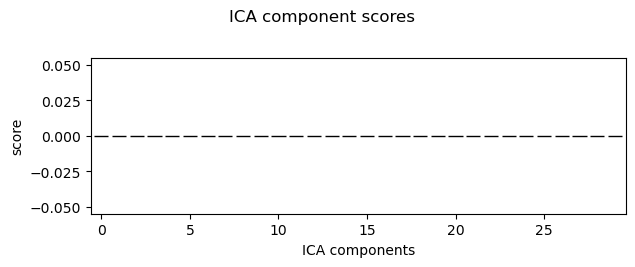

In [57]:
muscle_indices, muscle_scores = ica.find_bads_muscle(raw, threshold=0.5, sphere='eeglab')
ica.plot_scores(muscle_scores)

In [59]:
ica.exclude = eog_indices + ecg_indices + muscle_indices
ica.plot_sources(raw)

Creating RawArray with float64 data, n_channels=31, n_times=36038
    Range : 25800 ... 61837 =     42.956 ...   102.956 secs
Ready.


In [60]:
ica.apply(raw)

Applying ICA to Raw instance
    Transforming to ICA space (30 components)
    Zeroing out 3 ICA components
    Projecting back using 364 PCA components


<Raw | sample_audvis_raw.fif, 376 x 36038 (60.0 s), ~106.6 MB, data loaded>

In [61]:
raw.plot(order=artifact_picks, n_channels=len(artifact_picks), show_scrollbars=False)

## Trigger

In [62]:
events = mne.find_events(raw, stim_channel="STI 014")
print(events[:5])  # show the first 5

86 events found
Event IDs: [ 1  2  3  4  5 32]
[[27977     0     2]
 [28345     0     3]
 [28771     0     1]
 [29219     0     4]
 [29652     0     2]]


In [64]:
event_dict = {
    "auditory/left": 1,
    "auditory/right": 2,
    "visual/left": 3,
    "visual/right": 4,
    "smiley": 5,
    "buttonpress": 32,
}
fig = mne.viz.plot_events(
    events, event_id=event_dict, sfreq=raw.info["sfreq"], first_samp=raw.first_samp
)

fig.savefig('../figures/mne-trig2.png')

## Epocking

In [65]:
raw.plot()

In [96]:
eog_events = mne.preprocessing.find_eog_events(raw)
onsets = eog_events[:, 0] / raw.info["sfreq"] - 0.25
durations = [0.5] * len(eog_events)
descriptions = ["bad blink"] * len(eog_events)
blink_annot = mne.Annotations(
    onsets, durations, descriptions, orig_time=raw.info["meas_date"]
)

eeg_picks = mne.pick_types(raw.info, meg=False, eeg=True)
#raw.plot(events=eog_events, order=eeg_picks)

Using EOG channel: EOG 061
EOG channel index for this subject is: [375]
Filtering the data to remove DC offset to help distinguish blinks from saccades
Selecting channel EOG 061 for blink detection
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 6007 samples (10.001 s)

Now detecting blinks and generating corresponding events
Found 10 significant peaks
Number of EOG events detected: 10


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1.1e+02 - 1.4e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 110.00
- Lower transition bandwidth: 27.50 Hz (-6 dB cutoff frequency: 96.25 Hz)
- Upper passband edge: 140.00 Hz
- Upper transition bandwidth: 35.00 Hz (-6 dB cutoff frequency: 157.50 Hz)
- Filter length: 73 samples (0.122 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Setting up low-pass filter at 4 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 4.00 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 5.00 Hz)
- Filter length: 993 samples (1.653 s)



[Parallel(n_jobs=1)]: Done  59 out of  59 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


[Text(0.5, 0, 'time, (s)'),
 Text(0, 0.5, 'zscore'),
 Text(0.5, 1.0, 'Muscle activity')]

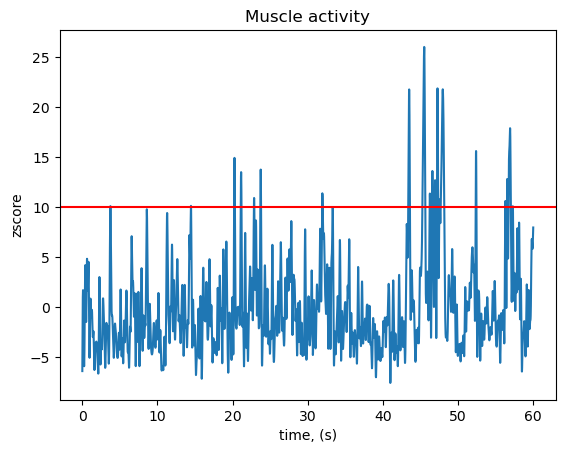

In [95]:
from mne.preprocessing import annotate_muscle_zscore
threshold_muscle = 10  # z-score
muscle_annot, scores_muscle = annotate_muscle_zscore(
    raw,
    ch_type="eeg",
    threshold=threshold_muscle,
    min_length_good=0.2,
    filter_freq=[110, 140],
)

fig, ax = plt.subplots()
ax.plot(raw.times, scores_muscle)
ax.axhline(y=threshold_muscle, color="r")
ax.set(xlabel="time, (s)", ylabel="zscore", title="Muscle activity")

In [97]:
raw.set_annotations(blink_annot + muscle_annot)
raw.plot()

Not setting metadata
86 matching events found
Setting baseline interval to [-0.19979521315838786, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 86 events and 421 original time points ...
18 bad epochs dropped


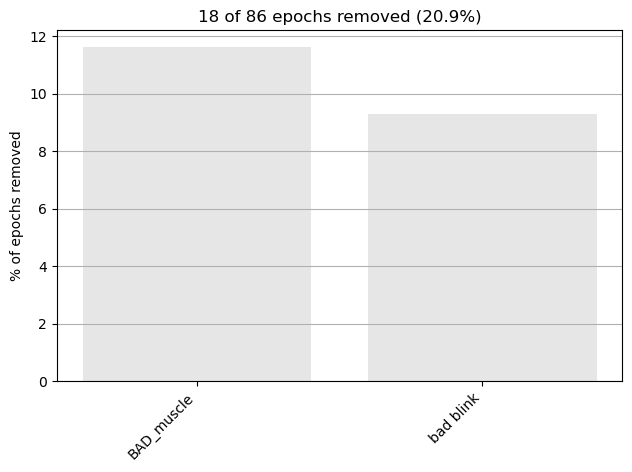

In [100]:
epochs = mne.Epochs(
    raw,
    events,
    tmin=-0.2,
    tmax=0.5,
    reject_tmin=-0.2,
    reject_tmax=0,
    reject=reject_criteria,
    flat=flat_criteria,
    reject_by_annotation=True,
    preload=True,
)
epochs.plot_drop_log() 

In [101]:
epochs

<Epochs |  68 events (all good), -0.199795 – 0.499488 s, baseline -0.199795 – 0 s, ~85.4 MB, data loaded,
 '1': 17
 '2': 16
 '3': 15
 '4': 14
 '5': 4
 '32': 2>